<a href="https://colab.research.google.com/github/bkrant/DS-Unit-2-Sprint-2-Regression/blob/master/Copy_of_LS_DS_411A_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [0]:
!pip install graphviz
!apt-get install graphviz

In [0]:
import graphviz
from IPython.display import display
from ipywidgets import interact
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
df = df.drop(columns=['Id'])
df['Ln_SalePrice'] = np.log(df['SalePrice'])
print(df.shape)
df.head(2)

(1460, 81)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Ln_SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011


In [0]:
df.LotFrontage = df.LotFrontage.fillna(np.mean(df.LotFrontage))
df.MasVnrArea  = df.MasVnrArea.fillna(np.mean(df.MasVnrArea))
df.GarageYrBlt = df.GarageYrBlt.fillna(np.mean(df.GarageYrBlt))

In [0]:
def run_decisiontree_model(X, y, max_depth=1):
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

    # Fit model using train data
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)

    # Make predictions using test features
    y_pred = model.predict(X_test)

    # Compare predictions to test target
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)

    #print('Decision tree Test Root Mean Squared Error', rmse)
    #print('Decision Tree Test R^2 Score', r2)
    return rmse
    
def run_linear_model(X, y):
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

    # Fit model using train data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions using test features
    y_pred = model.predict(X_test)

    # Compare predictions to test target
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)

    print('OLS Test Root Mean Squared Error', rmse)
    print('OLS Test R^2 Score', r2)

In [0]:
target = 'Ln_SalePrice'
features = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
            'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars']
run_linear_model(df[features], df[target])

OLS Test Root Mean Squared Error 0.16547362585654327
OLS Test R^2 Score 0.8532715040625406


In [0]:
df['BsmtFinSF1_squared'] = df['BsmtFinSF1']**2

In [0]:
target = 'Ln_SalePrice'
features = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
            'BsmtFinSF1_squared', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars']
run_linear_model(df[features], df[target])

OLS Test Root Mean Squared Error 0.1543475340020802
OLS Test R^2 Score 0.8723395739161997


In [0]:
rmse = np.array([])
for md in range(1,11):
  rmse = np.append(rmse, run_decisiontree_model(df[features], df[target], max_depth=md) )
rmse

array([0.30746526, 0.26460593, 0.23329948, 0.21311657, 0.19725402,
       0.19751337, 0.21716459, 0.21322608, 0.21846632, 0.21879964])

In [0]:
rmse.argmin()+1

5

In [0]:
tree = DecisionTreeRegressor(max_depth=rmse.argmin()+1)
tree.fit(df[features], df[target])

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [0]:
def viztree(decision_tree, feature_names):
    """Visualize a decision tree"""
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)


def viz3D(fitted_model, df, feature1, feature2, target='', num=100):
    """
    Visualize model predictions in 3D, for regression or binary classification
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    df : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
    https://scikit-learn.org/stable/auto_examples/tree/plot_iris.html  
    """
    x1 = np.linspace(df[feature1].min(), df[feature1].max(), num)
    x2 = np.linspace(df[feature2].min(), df[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,1]
    else:
        predicted = fitted_model.predict(X)
    Z = predicted.reshape(num, num)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X1, X2, Z, cmap='viridis')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(target)
    return fig

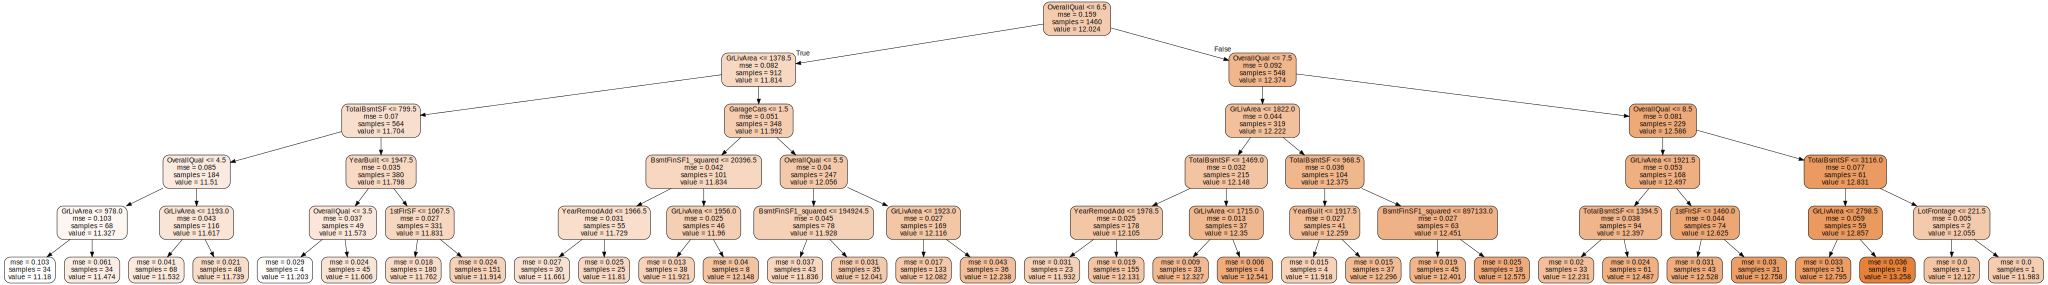

In [0]:
viztree(tree, feature_names=features)

## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [0]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [0]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [0]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [0]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [0]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [0]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

(14, 10) (14,)


,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html